In [186]:
#wine
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, cross_validate, train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

from sklearn import tree
import graphviz

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

#load data
df = pd.read_csv (r'./data/wine.csv')

#preprocessing
# convert target to binary
df.loc[df.quality =='bad', "quality"] = 0 #bad wine
df.loc[df.quality == 'good', "quality"] = 1 #good wine
#get the target
y = df.pop('quality')
#scale features
X_scaled = preprocessing.scale(df)

#split train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

In [187]:
#grid search to find best paramteres
params = {'alpha': [0.00001,0.0001,0.001]
          #epochs
          , 'max_iter': [12,15,17,20,23,27]
          , 'hidden_layer_sizes' : [(8,),(10,),(11,),(12,),(14,)]
                      }
grid_search_cv = GridSearchCV(MLPClassifier(random_state = 42, solver = 'lbfgs')
                              , params
                              , scoring = "accuracy"
                              , verbose=1
                              , cv=5
                              ,n_jobs=5)
grid_search_cv.fit(X_train, y_train);

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 320 tasks      | elapsed:   11.1s
[Parallel(n_jobs=5)]: Done 450 out of 450 | elapsed:   13.4s finished


In [188]:
print("Best estimators: ", grid_search_cv.best_estimator_)

Best estimators:  MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(12,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=20,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


In [189]:
#model with default features. note we are using lbfgsand not default to avoid long runs.
print("ANN with default params accuracy: ", cross_val_score(MLPClassifier(solver = 'lbfgs',random_state = 42), X_train, y_train, cv=5, scoring='accuracy').mean())
print("ANN with tuned hyper paramaters accuracy: ", cross_val_score(grid_search_cv.best_estimator_, X_train, y_train, cv=5, scoring='accuracy').mean())

ANN with default params accuracy:  0.7365165441176471
ANN with tuned hyper paramaters accuracy:  0.760765931372549


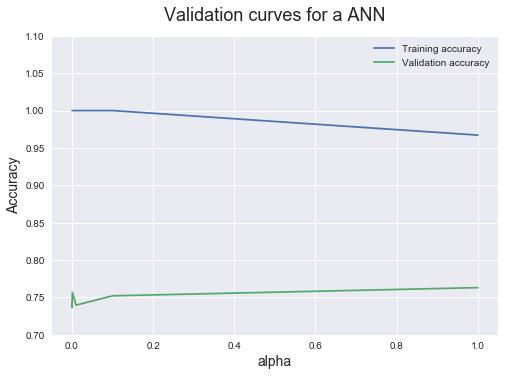

In [190]:
#plot validation curve
alpha_range = [0.00001, 0.0001,0.001,0.01,0.1,1]
train_scores, valid_scores = validation_curve(MLPClassifier(solver = 'lbfgs'
                                                            ,random_state = 42
                                                           #,hidden_layer_sizes=(12,)
                                                           #, max_iter = 20
                                                           ),
                                              X_train,
                                              y_train,
                                              param_name = "alpha",
                                              param_range = alpha_range,
                                              scoring='accuracy',
                                             cv=5)

plt.style.use('seaborn')
plt.plot(alpha_range, train_scores.mean(axis=1), label = 'Training accuracy')
plt.plot(alpha_range, valid_scores.mean(axis=1), label = 'Validation accuracy')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('alpha', fontsize = 14)
plt.title('Validation curves for a ANN', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0.7,1.1)
plt.show()

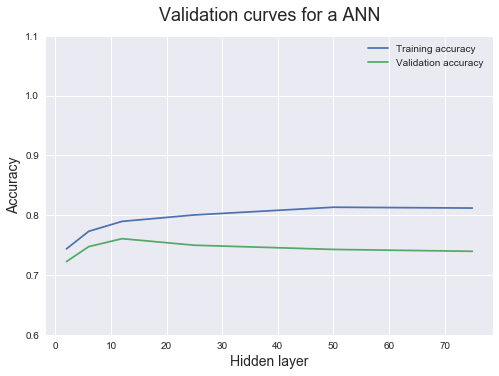

In [191]:
#plot validation curve
#1. number of nodes in 1 layer NN.


hidden_layer_range = [(2,),(6,),(12,),(25,),(50),(75,)]
hidden_layer = [2,6,12,25,50,75]
train_scores, valid_scores = validation_curve(MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(12,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=20,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False),
                                              X_train,
                                              y_train,
                                              param_name = "hidden_layer_sizes",
                                              param_range = hidden_layer_range,
                                              scoring='accuracy',
                                             cv=5)

plt.style.use('seaborn')
plt.plot(hidden_layer, train_scores.mean(axis=1), label = 'Training accuracy')
plt.plot(hidden_layer, valid_scores.mean(axis=1), label = 'Validation accuracy')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Hidden layer', fontsize = 14)
plt.title('Validation curves for a ANN', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0.6,1.1)
plt.show()

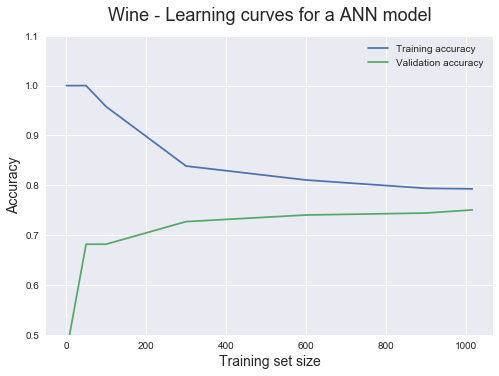

In [192]:
#learning curve

train_sizes = [1,50, 100, 300, 600, 900, 1016]

train_sizes, train_scores, validation_scores = learning_curve(
               estimator = grid_search_cv.best_estimator_,
               X = X_train,
               y = y_train,
               train_sizes = train_sizes,
               cv = 5,
               scoring = 'accuracy')

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
#print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
#print('\n', '-' * 20) # separator
#print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))


plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training accuracy')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation accuracy')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Wine - Learning curves for a ANN model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0.5,1.1)
plt.show()

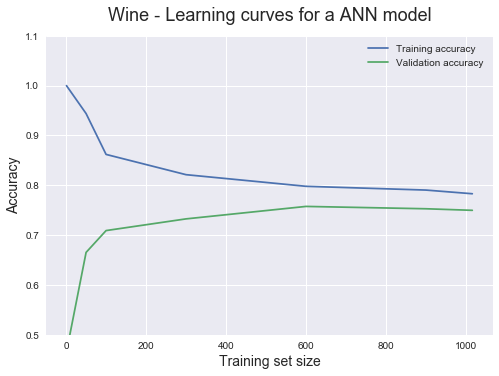

In [214]:
#learning curve

train_sizes = [1,50, 100, 300, 600, 900, 1016]

train_sizes, train_scores, validation_scores = learning_curve(
               estimator = model, #grid_search_cv.best_estimator_,
               X = X_train,
               y = y_train,
               train_sizes = train_sizes,
               cv = 5,
               scoring = 'accuracy')

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
#print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
#print('\n', '-' * 20) # separator
#print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))


plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training accuracy')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation accuracy')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Wine - Learning curves for a ANN model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0.5,1.1)
plt.show()

In [234]:
test_acc =[]
for iter in range(1,20):
    model = MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(12,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=iter,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
    model.fit(X_train, y_train)
    pred_y = model.predict(X_test)
    test_acc.append(accuracy_score(y_test, pred_y))
#loss_values = model.loss_curve_
#print (loss_values)

In [235]:
test_acc

[0.6625,
 0.740625,
 0.7375,
 0.728125,
 0.728125,
 0.74375,
 0.73125,
 0.7375,
 0.728125,
 0.728125,
 0.75625,
 0.75625,
 0.740625,
 0.746875,
 0.753125,
 0.753125,
 0.753125,
 0.75,
 0.740625]

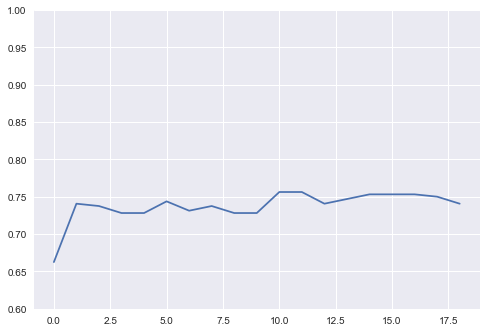

In [238]:
plt.plot(test_acc)
plt.ylim(0.6,1)
plt.show()

In [227]:
test_acc

0.25312500000000004

In [223]:
#model with default features
#print("SVM with default params accuracy: ", cross_val_score(SVC(kernel='rbf'), X_train, y_train, cv=5, scoring='accuracy').mean())
print("SVM with tuned hyper paramaters accuracy: ", cross_val_score(grid_search_cv.best_estimator_, X_train, y_train, cv=5, scoring='accuracy').mean())
print("SVM with LC params accuracy: ", cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean())

SVM with tuned hyper paramaters accuracy:  0.760765931372549
SVM with LC params accuracy:  0.7122671568627451


In [72]:
#diabetes
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, cross_validate, train_test_split
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt

from sklearn import tree

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.neural_network import MLPClassifier

#load data
df = pd.read_csv (r'./data/diabetes.csv')

#preprocessing
# convert target to binary
df.loc[df["class"] =='tested_negative', "class"] = 0
df.loc[df["class"] == 'tested_positive', "class"] = 1

#get the target
y = df.pop('class')
#scale features
X_scaled = preprocessing.scale(df)

oversample = BorderlineSMOTE(random_state=42)
X_scaled, y = oversample.fit_resample(X_scaled, y)


#split train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

In [73]:
#grid search to find best paramteres
params = {'alpha': [0.00001,0.0001,0.001]
                        , 'max_iter': [12,15,17,20,23,27,50,100]
                        , 'hidden_layer_sizes' : [(8,),(10,),(11,),(12,),(14,),(7,7),(12,12),(25,25)]
                      }
grid_search_cv = GridSearchCV(MLPClassifier(solver = 'lbfgs',random_state = 42)
                              , params
                              , scoring = "f1"
                              , verbose=1
                              , cv=5
                              ,n_jobs=5)
grid_search_cv.fit(X_train, y_train);

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done 325 tasks      | elapsed:   10.6s
[Parallel(n_jobs=5)]: Done 825 tasks      | elapsed:   20.9s
[Parallel(n_jobs=5)]: Done 951 out of 960 | elapsed:   25.0s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 960 out of 960 | elapsed:   26.5s finished


In [74]:
print("Best estimators: ", grid_search_cv.best_estimator_)

Best estimators:  MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(12, 12), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=17,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


In [52]:
#model with default features
print("ANN with default params f1: ", cross_val_score(MLPClassifier(), X_train, y_train, cv=5, scoring='f1').mean())
print("ANN with tuned hyper paramaters f1: ", cross_val_score(grid_search_cv.best_estimator_, X_train, y_train, cv=5, scoring='f1').mean())

ANN with default params f1:  0.7687448397711473
ANN with tuned hyper paramaters f1:  0.7829315375521251


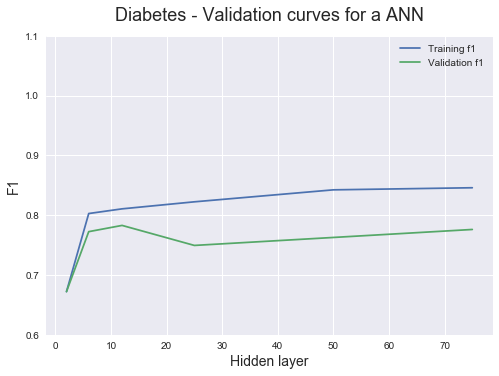

In [75]:
#plot validation curve
#1. number of nodes in 1 layer NN.


#hidden_layer_range = [(2,),(6,),(12,),(25,),(50),(75,)]
hidden_layer_range = [(2,2),(6,6),(12,12),(25,25),(50,50),(75,75)]
hidden_layer = [2,6,12,25,50,75]
train_scores, valid_scores = validation_curve(MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
               learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=17,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False),
                                              X_train,
                                              y_train,
                                              param_name = "hidden_layer_sizes",
                                              param_range = hidden_layer_range,
                                              scoring='f1',
                                             cv=5)

plt.style.use('seaborn')
plt.plot(hidden_layer, train_scores.mean(axis=1), label = 'Training f1')
plt.plot(hidden_layer, valid_scores.mean(axis=1), label = 'Validation f1')
plt.ylabel('F1', fontsize = 14)
plt.xlabel('Hidden layer', fontsize = 14)
plt.title('Diabetes - Validation curves for a ANN', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0.6,1.1)
plt.show()

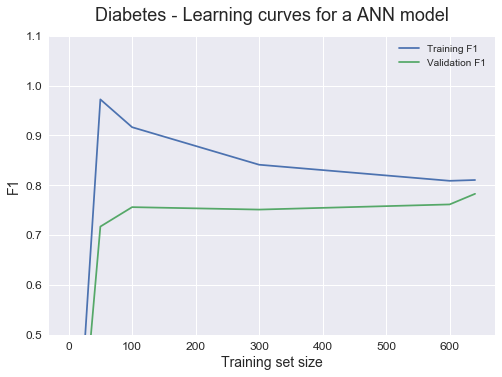

In [78]:
#learning curve

train_sizes = [1,50, 100, 300, 600, 640]

train_sizes, train_scores, validation_scores = learning_curve(
               estimator = grid_search_cv.best_estimator_,
               X = X_train,
               y = y_train,
               train_sizes = train_sizes,
               cv = 5,
               scoring = 'f1')

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
#print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
#print('\n', '-' * 20) # separator
#print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))


plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training F1')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation F1')
plt.ylabel('F1', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Diabetes - Learning curves for a ANN model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0.5,1.1)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.show()

In [77]:
#model with default features
print("ANN with default params F1: ", cross_val_score(MLPClassifier(random_state=42), X_train, y_train, cv=5, scoring='f1').mean())
print("ANN with tuned hyper paramaters F1: ", cross_val_score(grid_search_cv.best_estimator_, X_train, y_train, cv=5, scoring='f1').mean())
#print("ANN with tuned LC paramaters F1: ", cross_val_score(mlp_dia, X_train, y_train, cv=5, scoring='f1').mean())

ANN with default params F1:  0.7664146859701416
ANN with tuned hyper paramaters F1:  0.7829315375521251
